<h3>Linearity Measurements<h3>

This code will get the linearity measurements of a circuit
- P1dB
- IIP2
- IIP3

Instructions:
1. Turn on the signal generator and the oscilloscope
2. Connect their USB cables to the PC
3. Set the desired frequencies 
4. Set the desired amplitude range

In [1]:
# Reloading
%load_ext autoreload
%autoreload 2

In [12]:
# Imports Section
import re
import sys
import time
import pyvisa
import logging
import numpy as np
import matplotlib.pyplot as plt
from oscilloscope import Oscilloscope
from signal_generator import SignalGenerator
from linearity_measurement import LinearityMeasurement

# Set up logging
logging.getLogger('pyvisa').setLevel(logging.WARNING)

# Set up VISA addresses
osc_address = 'USB0::0x1AB1::0x04CE::DS1ZA232605402::INSTR'
sg_address = 'USB0::0x1AB1::0x0642::DG1ZA232402828::INSTR'

# Create an instance of the Oscilloscope class
osc = Oscilloscope(osc_address)
sg = SignalGenerator(sg_address)

# Initialize the linearity measurement class
lm = LinearityMeasurement(sg, osc)

# Query Identities
print("Oscilloscope ID:", osc.idn())
print("Signal Generator ID:", sg.idn())

Oscilloscope ID: RIGOL TECHNOLOGIES,DS1054Z,DS1ZA232605402,00.04.05.SP1
Signal Generator ID: Rigol Technologies,DG1022Z,DG1ZA232402828,03.01.12  


<h4>Main Loop for Linearity Measurements<h4>

In [18]:
"""Variables"""
start_voltage = 1e-3
stop_voltage = 1
num = 4
freq1 = 1e3 
freq2 = 1.01e3

"""Measure IIP2 (second-order intercept point)."""
input_voltages = np.round(np.linspace(start_voltage, stop_voltage, num),2)
second_order_products = []

# Oscilloscope Settings for a certain frequency and amplitude
ln.set_oscilloscope(freq1, start_voltage)

# Allow time for the instrument to configure
time.sleep(1)

for voltage in input_voltages:
    # Set two-tone signal with specified power
    sg.set_waveform("SIN", frequency=freq1, amplitude=voltage, offset=0)
    sg.enable_output()
    
    # Oscilloscope Settings for a certain frequency and amplitude
    ln.set_oscilloscope(freq1, voltage)
    print(voltage)
    
    # Oscilloscope Settings for frequency and amplitude
    time.sleep(1) 
    osc.run()
    
    # Allow time for the instrument to configure
    time.sleep(1)  
    
    # Measure the output from the oscilloscope (assuming two-tone output capture)
    waveform_volts = osc.get_waveform_data(channel=1)
    time.sleep(1)
    
    # Allow time for the instrument to configure
    osc.stop()
    
sg.disable_output()

0.0
0.33
0.67
1.0


In [6]:
fs = osc.get_inferred_sampling_frequency()

"""Calculate second-order intermodulation product from waveform."""
# Perform FFT to find second-order intermodulation products at f1+f2 and f1-f2
fft     = np.fft.fft(waveform_volts)
freqs   = np.fft.fftfreq(len(waveform_volts),1/fs)

# Take the absolute value to get the magnitude
fft_magnitude = np.abs(fft[:len(fft) // 2]) / len(fft[:len(fft) // 2])
fft_freq  = freqs[:len(fft) // 2]

# Find the power at f1+f2 (second-order sum) and f1-f2 (second-order difference)
f_sum = freq1 + freq2
f_diff = np.abs(freq1 - freq2)
print(f"Frequencies = {f_sum, f_diff} Hz")

# Find the indices of the corresponding frequencies
idx_sum = np.argmin(np.abs(np.float64(fft_freq) - f_sum))
idx_diff = np.argmin(np.abs(np.float64(fft_freq) - f_diff))
print(f"Indices = {idx_sum, idx_diff} Hz")

# Calculate the power of the second-order products
second_order_power_sum = fft_magnitude[idx_sum] ** 2
second_order_power_diff = fft_magnitude[idx_diff] ** 2

# Return the maximum power between f1+f2 and f1-f2, converted to dBm
second_order_power = max(second_order_power_sum, second_order_power_diff)

print(second_order_power_diff,second_order_power_sum)

NameError: name 'waveform_volts' is not defined

In [32]:
array = np.array([1, -5, 20, 5, 30])
min_index = np.argmin(array)
print(f"Index of the minimum value: {min_index}")

# Perform IIP2 measurement
fs = osc.get_inferred_sampling_frequency()
input_voltages, second_order_products = lm.measure_iip2(0.1, 2, 10, 1e3, 1.01e3, fs)
# print(second_order_power)

Index of the minimum value: 1


Sweeping Voltages: 100%|██████████| 10/10 [01:05<00:00,  6.53s/it]

IIP2 found at input power = 14.903008161369156 dBm


<h4>Plotting<h4>

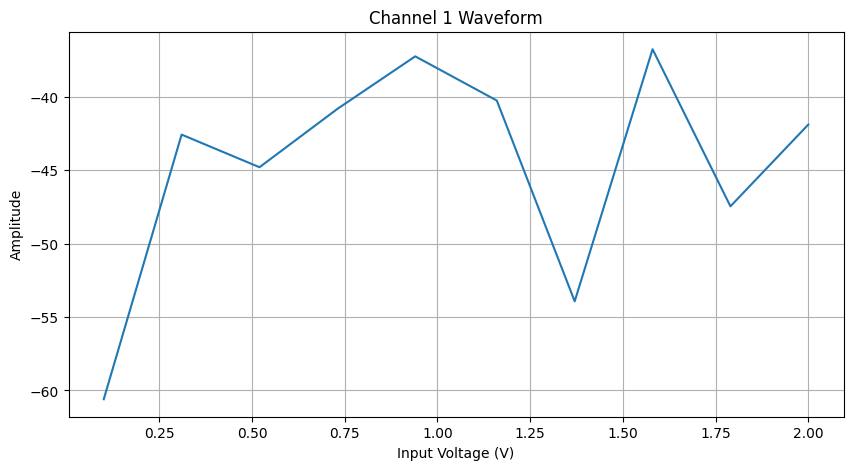

In [31]:
# Step 5: Plot the data
plt.figure(figsize=(10, 5))
# plt.plot(fft_freq/1e3,fft_magnitude)
plt.plot(input_voltages,second_order_products)
plt.title('Channel 1 Waveform')
plt.xlabel('Input Voltage (V)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

In [4]:
# Close the connections
osc.close()
sg.close()